In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [70]:
from  keras.utils import get_file

#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

#content_name,style_name = 'YellowLabradorLooking_new.jpg','kandinsky5.jpg'
content_name,style_name = 'YellowLabradorLooking_new.jpg','Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'
style_transfer_url  = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'
base_url  = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'


#content_name,style_name = 'bilbao.jpg','skyscraper.jpg'
#style_transfer_url = "https://i.imgur.com/9ooB60I.jpg"
#base_url = "https://tourism.euskadi.eus/contenidos/d_destinos_turisticos/0000004981_d2_rec_turismo/en_4981/images/CT_cabecerabilbaoguggen.jpg"


style_image_path = get_file(fname = style_name, origin = style_transfer_url)
base_image_path = get_file(fname = content_name, origin = base_url)
print(style_image_path, base_image_path)


/root/.keras/datasets/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg /root/.keras/datasets/YellowLabradorLooking_new.jpg


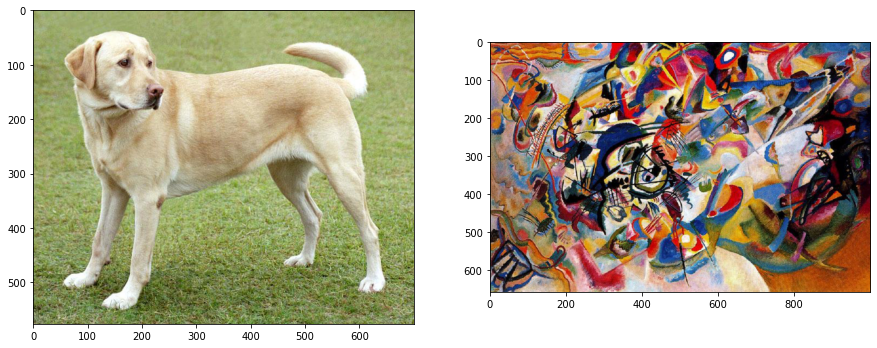

In [71]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

base_image = plt.imread(base_image_path)
style_image = plt.imread(style_image_path)
f, axxarr = plt.subplots(1,2, figsize=(15,15))
axxarr[0].imshow(base_image)
axxarr[1].imshow(style_image)

In [72]:
def gram_matrix(x):
  x = tf.transpose(x, (2,0,1))
  features = tf.reshape(x, (tf.shape(x)[0], -1) )
  gram = tf.matmul(features, tf.transpose(features))
  return gram
  


In [73]:
def cost_style(style_image, new_image):
  S = gram_matrix(style_image)
  N = gram_matrix(new_image)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - N)) / (4.0 * (channels**2) *(size**2) )

In [74]:
def cost_content(content_image, new_image):
  return tf.reduce_sum( tf.square(content_image - new_image)  )
  

In [75]:
from tensorflow.keras.applications import vgg19
from keras.utils import plot_model

model = vgg19.VGG19( weights='imagenet', include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [76]:
from keras import Model

output_dict = dict([(layer.name, layer.output) for layer in model.layers  ])

feature_extractor  = Model(inputs=model.inputs, outputs=output_dict)
#feature_extractor.summary()

In [90]:
capas_styles = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',               
]
print("-------")

capas_content = 'block5_conv2'
content_weight = 2.52e-5
style_weight = 1e-6


def loss_function(combined_image, base_image, style_image):
  input_tensor = tf.concat([base_image, style_image, combined_image], axis=0)
  
  features = feature_extractor(input_tensor)
  
  #print(features.keys())

  loss = tf.zeros(shape=())

  layer_features = features[capas_content]

  base_image_features = layer_features[0,:,:,:]
  combination_features = layer_features[2,:,:,:]

  loss = loss + content_weight * cost_content(base_image_features, combination_features)

  for layer_name in capas_styles:
    layer_features = features[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2, :, :, :]
    sl = cost_style(style_features, combination_features)
    #print(type(sl))
    loss += (style_weight/len(capas_styles)) * sl

  return loss


-------


In [91]:
def compute_loss_and_grad(new_image, base_image, style_image):
  with tf.GradientTape() as tape:
    loss = loss_function(new_image, base_image, style_image)
  grads = tape.gradient(loss, new_image)
  return loss, grads


In [92]:
import keras

def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)
  

In [93]:
def deprocess_image(x):
  x.reshape((img_nrows, img_ncols,3))
  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68

  x = x[:,:,::-1]

  x = np.clip(x, 0, 255).astype("uint8")

  return x

  

In [94]:
from datetime import datetime

def result_saver(iteration, new_image):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(new_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)
  plt.figure(figsize=(15,15))
  plt.imshow(plt.imread(image_name))
  plt.show()

Iteration 10: loss=324899.50


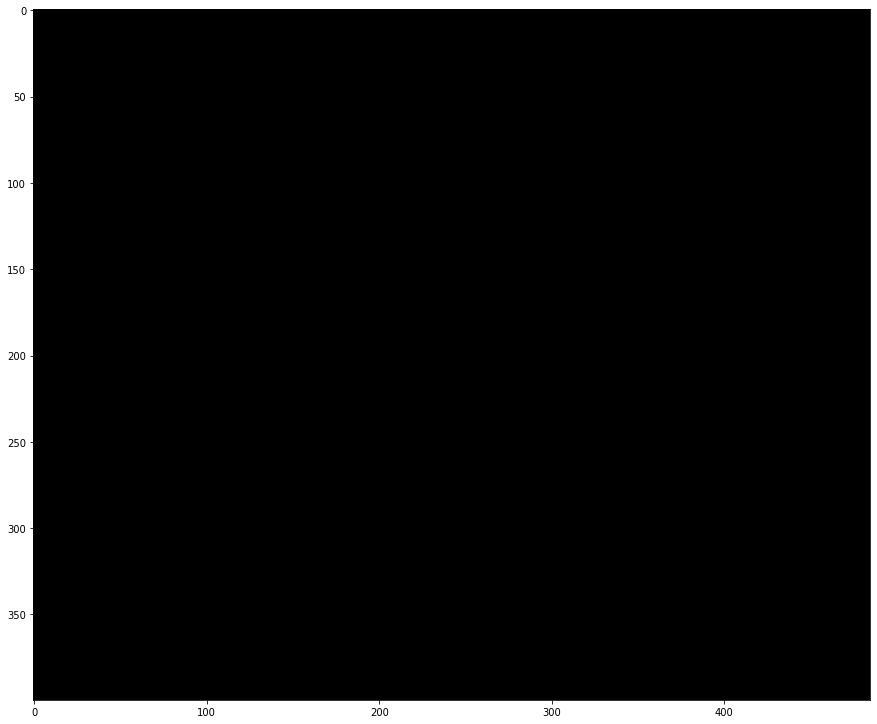

Iteration 20: loss=324899.50


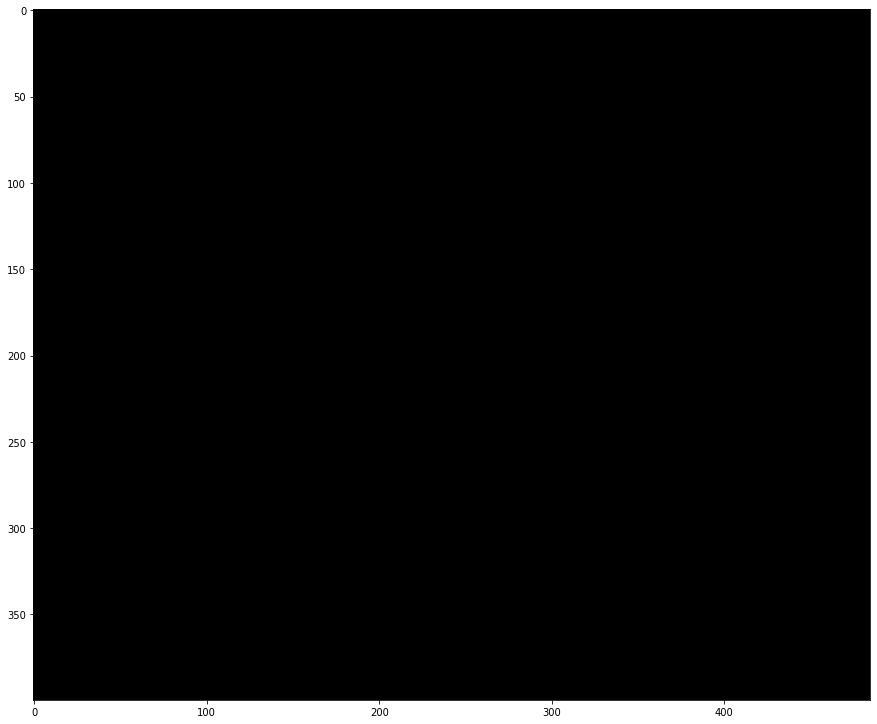

Iteration 30: loss=324899.50


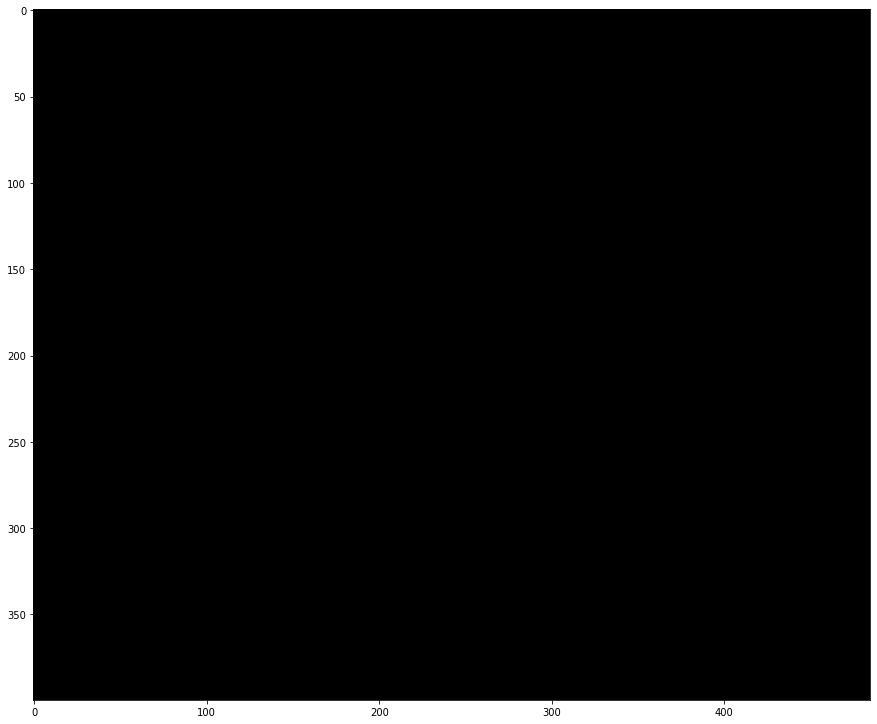

Iteration 40: loss=324899.50


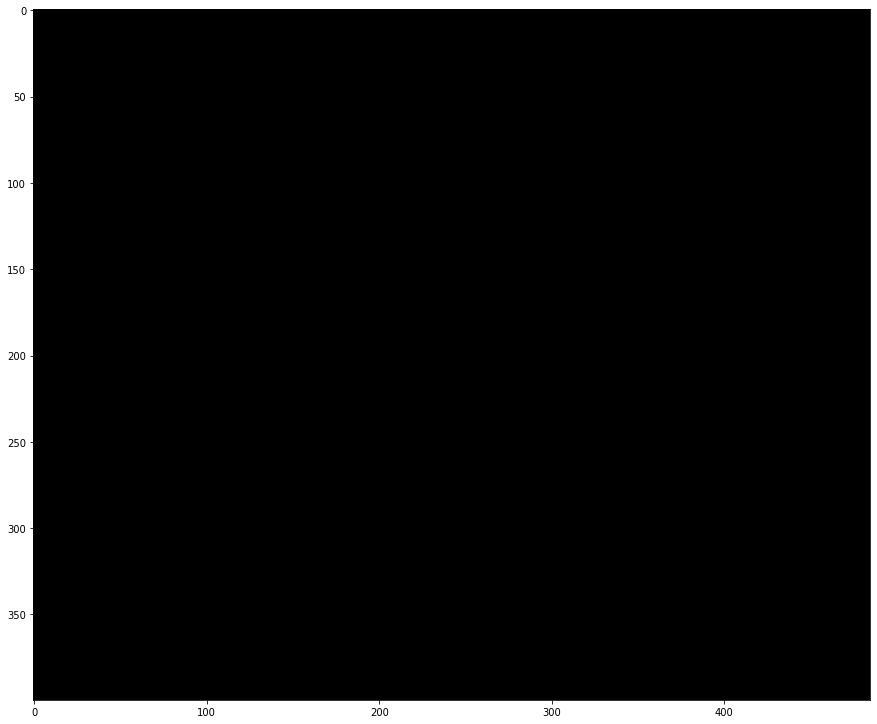

Iteration 50: loss=324899.50


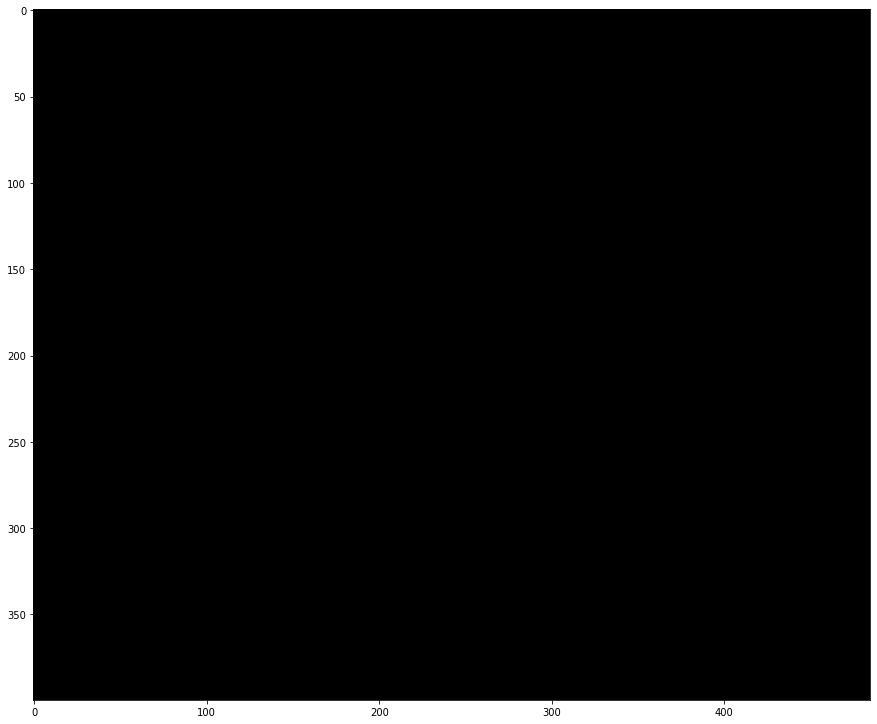

Iteration 60: loss=324899.50


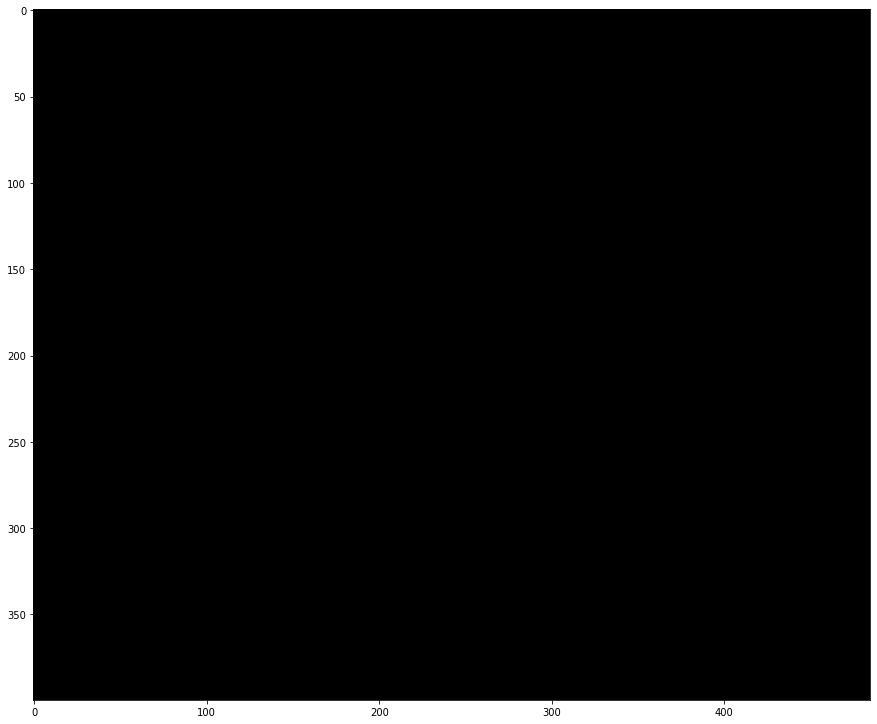

Iteration 70: loss=324899.50


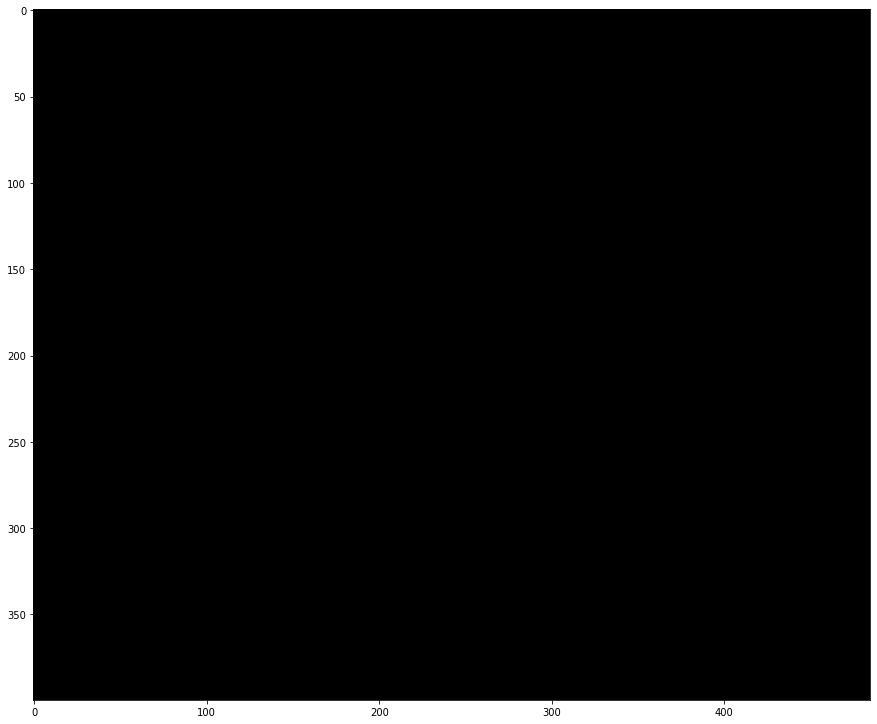

Iteration 80: loss=324899.50


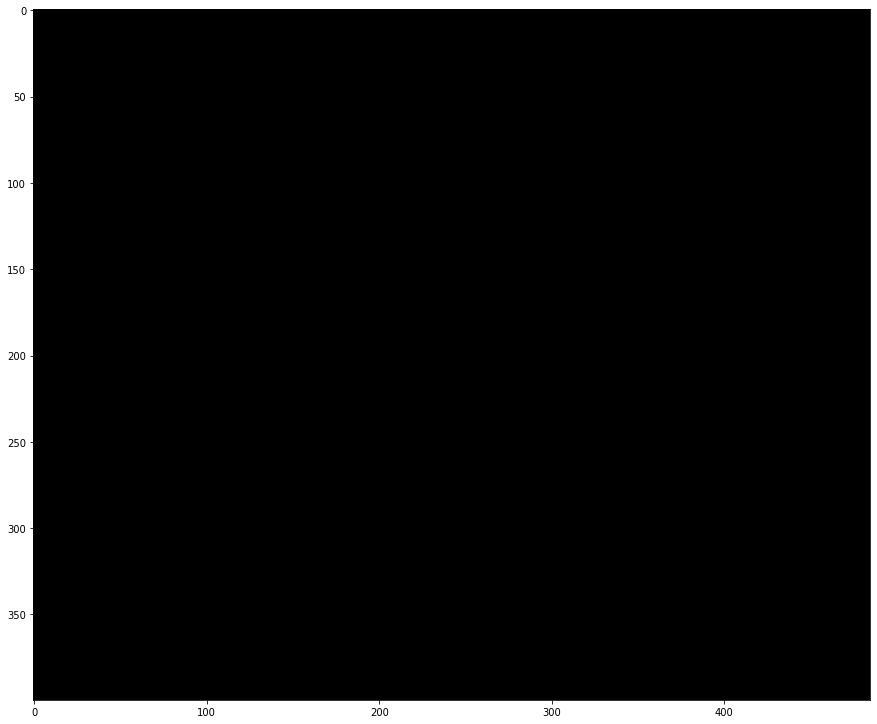

Iteration 90: loss=324899.50


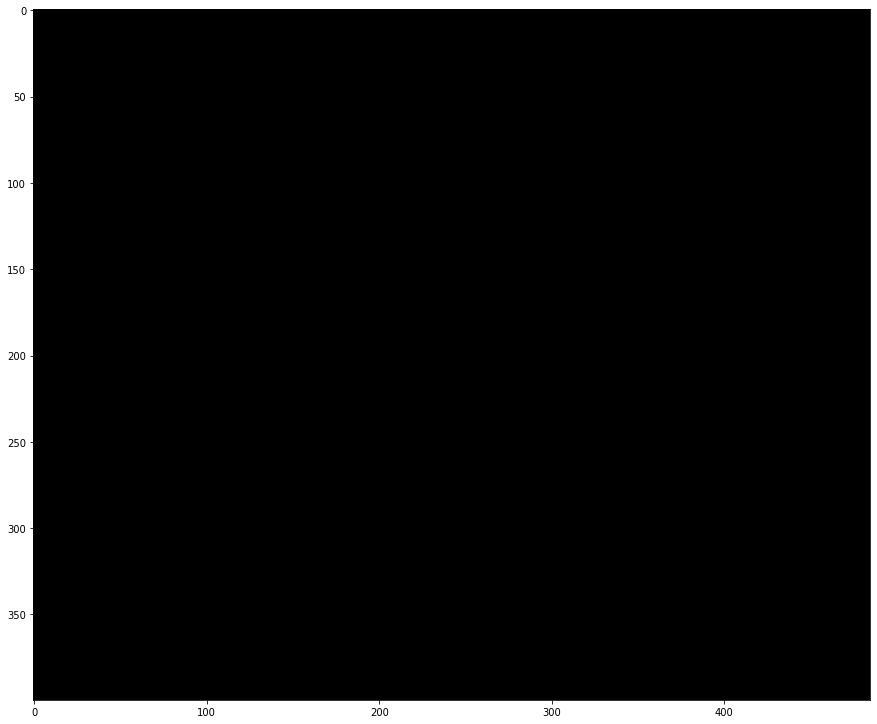

Iteration 100: loss=324899.50


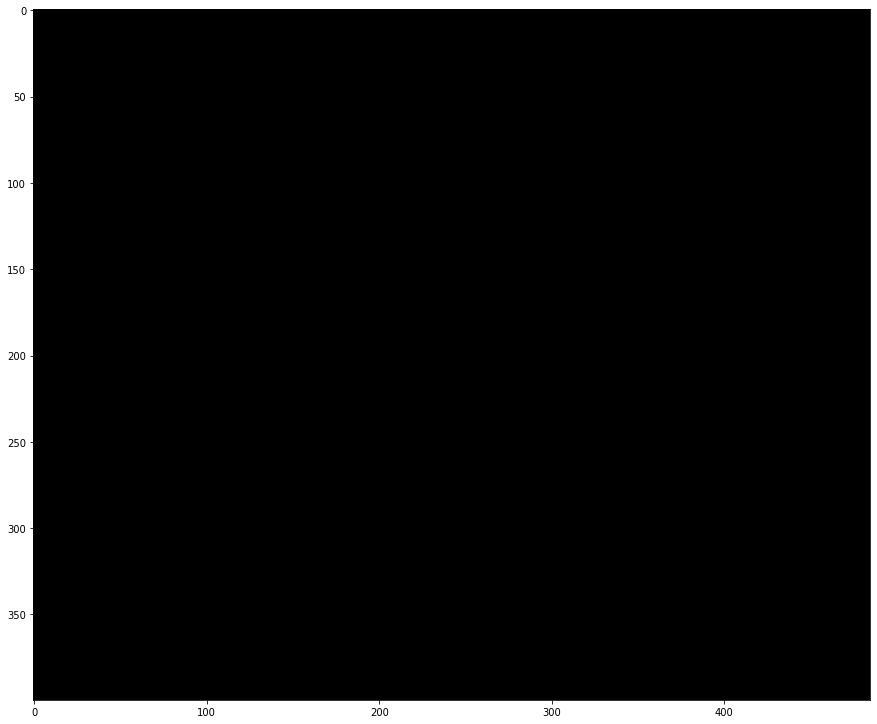

Iteration 110: loss=324899.50


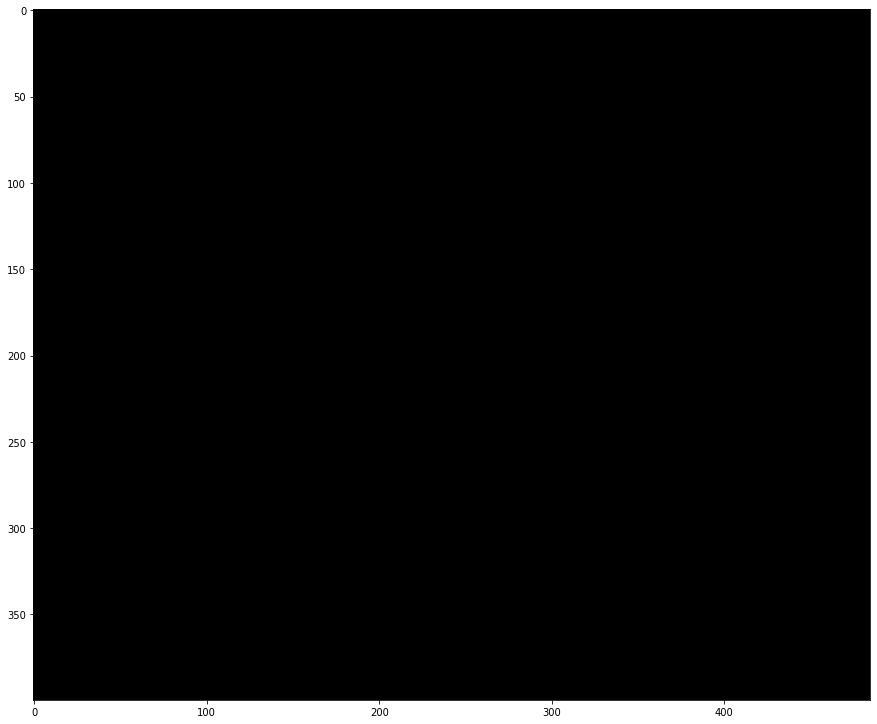

Iteration 120: loss=324899.50


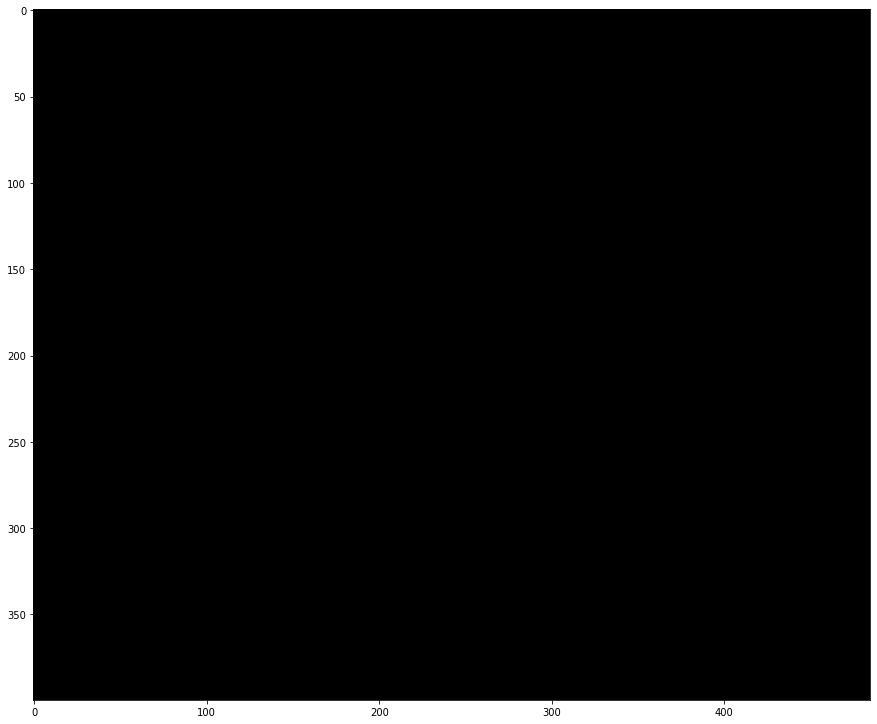

Iteration 130: loss=324899.50


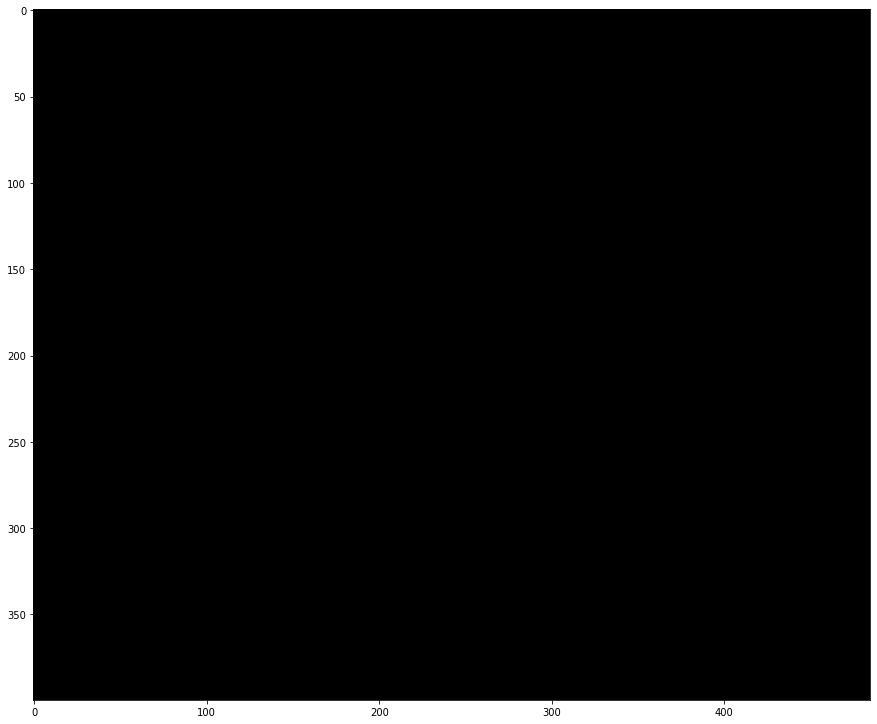

Iteration 140: loss=324899.50


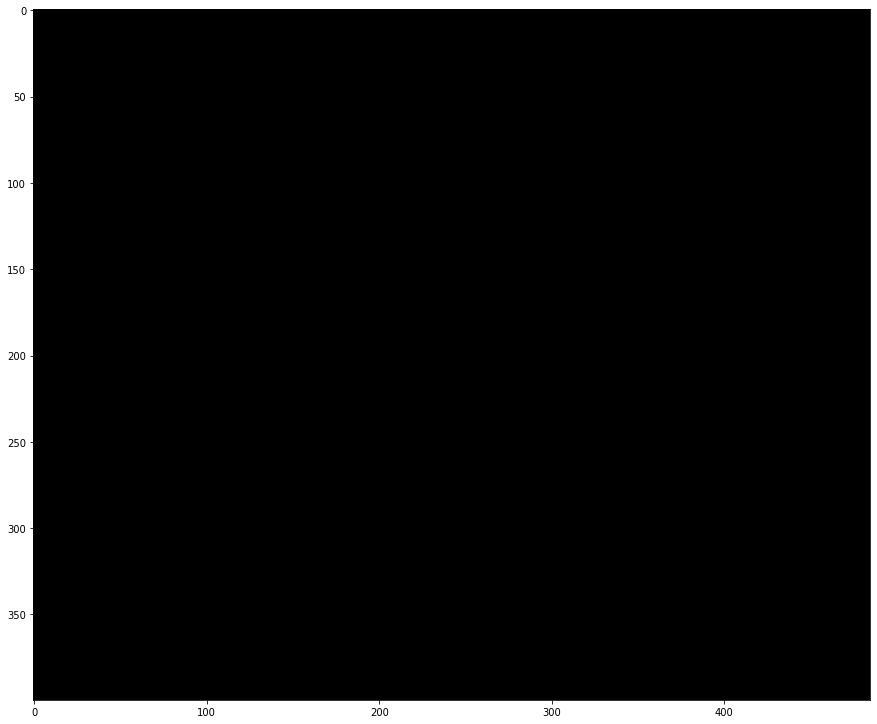

Iteration 150: loss=324899.50


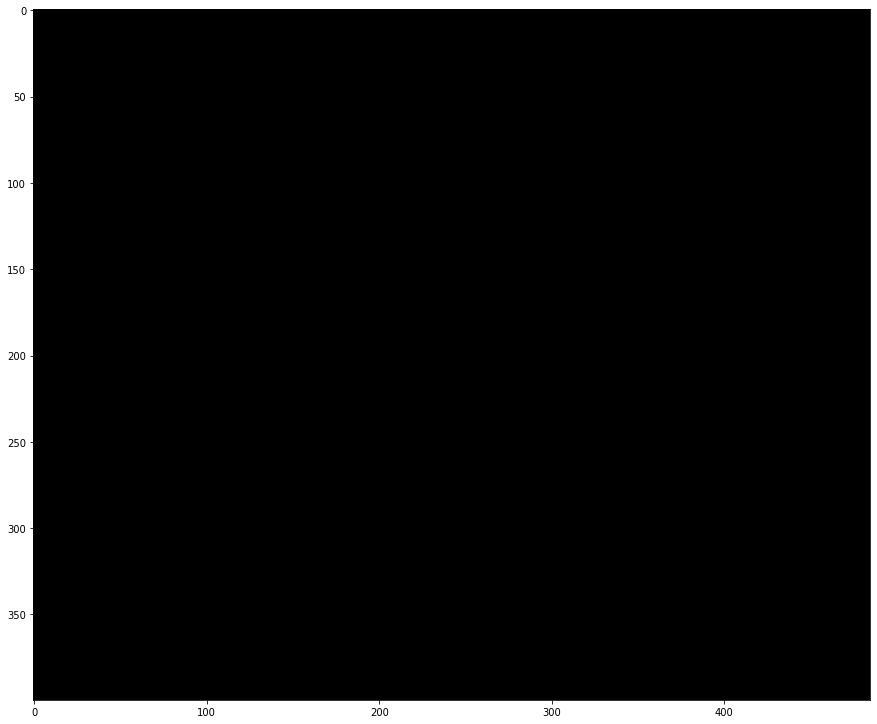

Iteration 160: loss=324899.50


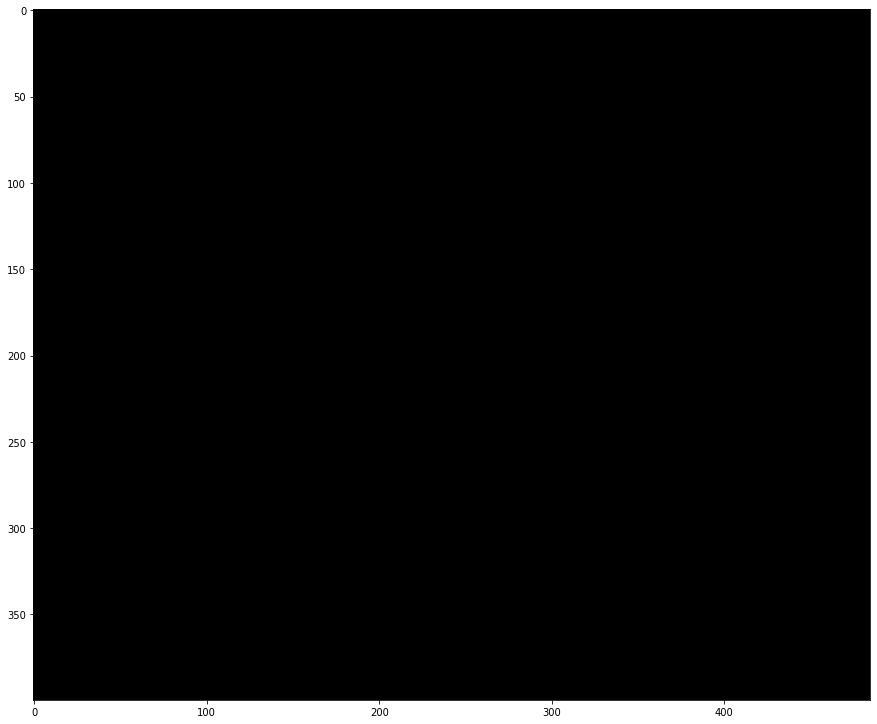

Iteration 170: loss=324899.50


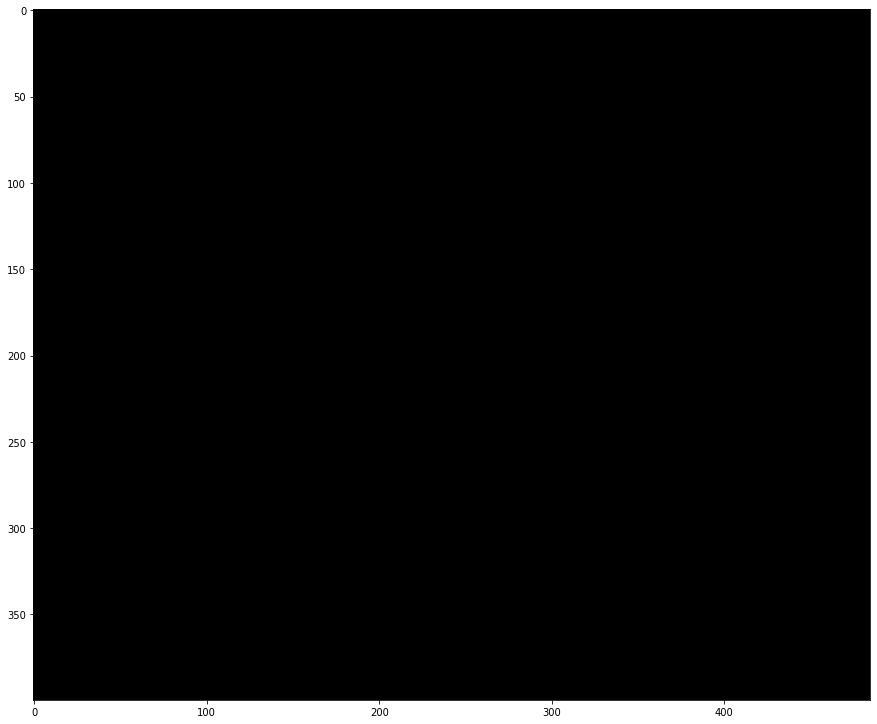

Iteration 180: loss=324899.50


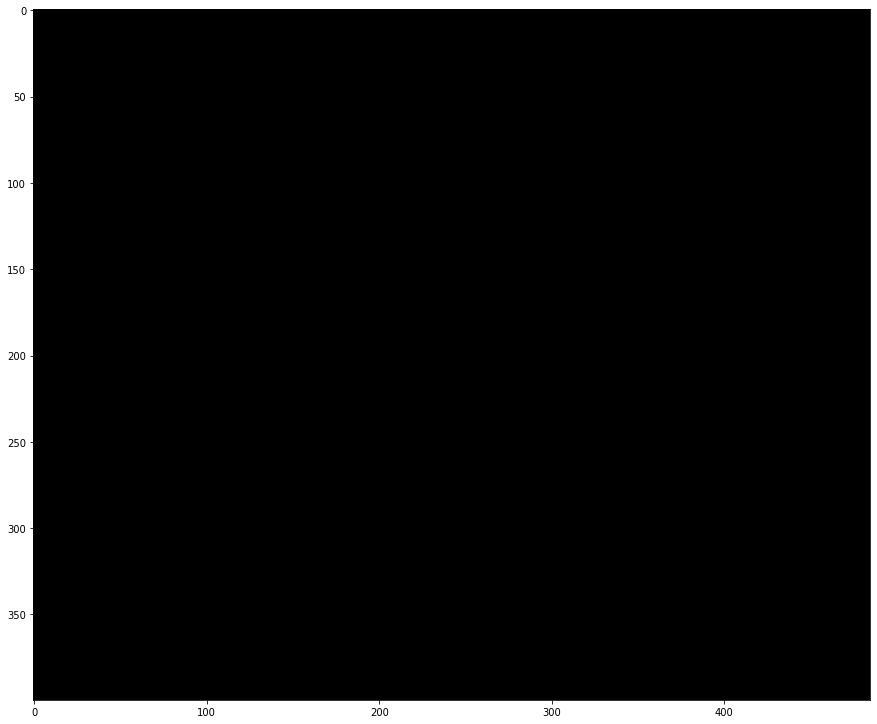

Iteration 190: loss=324899.50


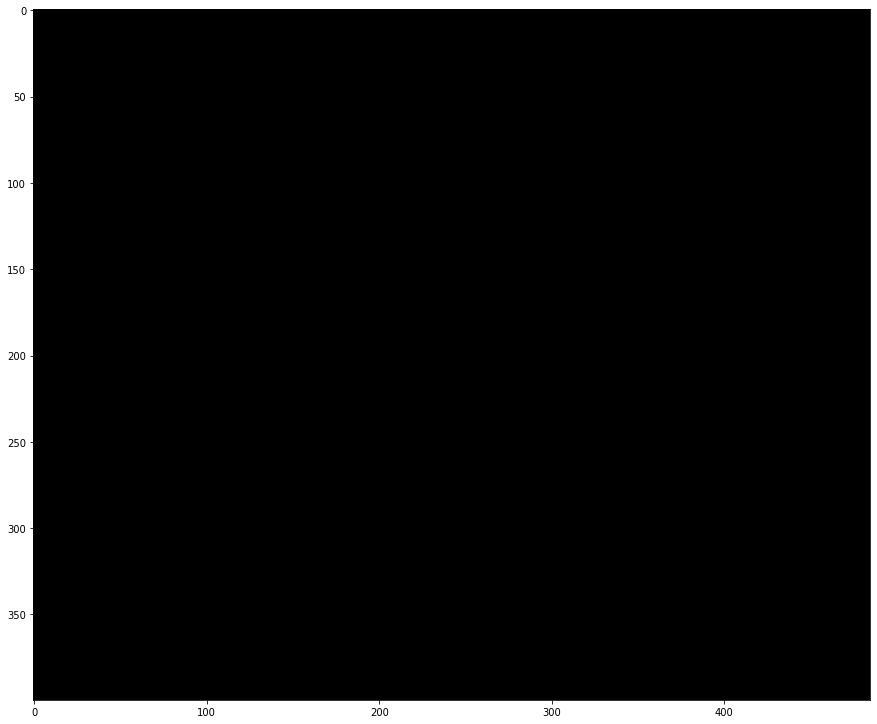

Iteration 200: loss=324899.50


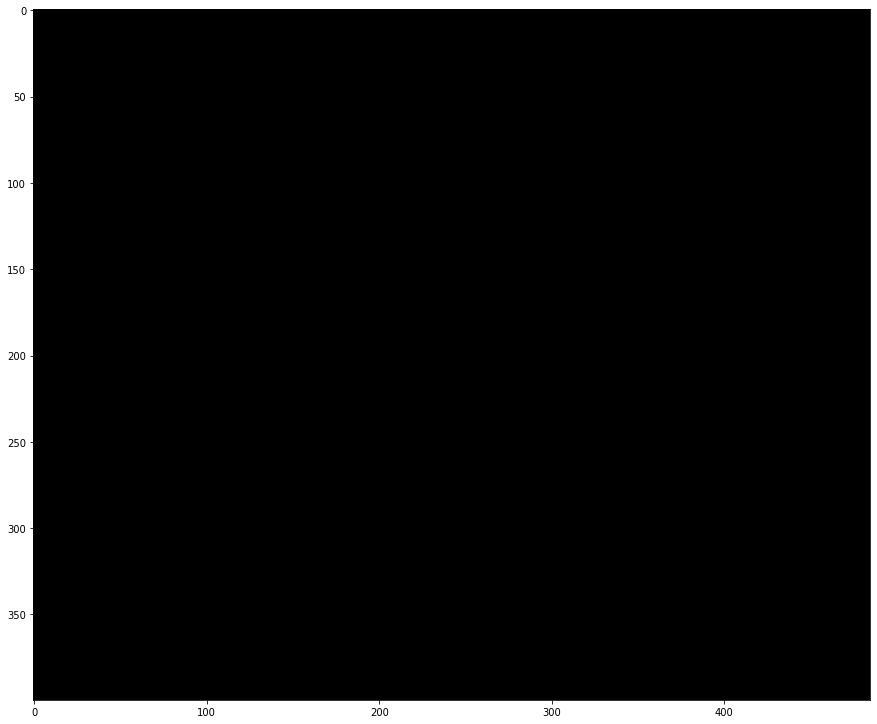

Iteration 210: loss=324899.50


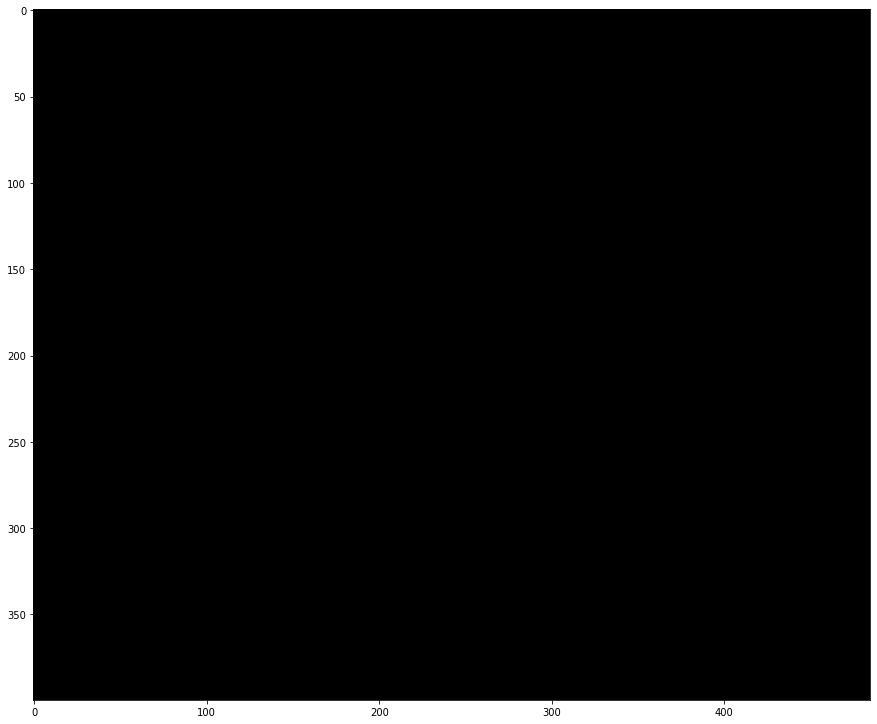

Iteration 220: loss=324899.50


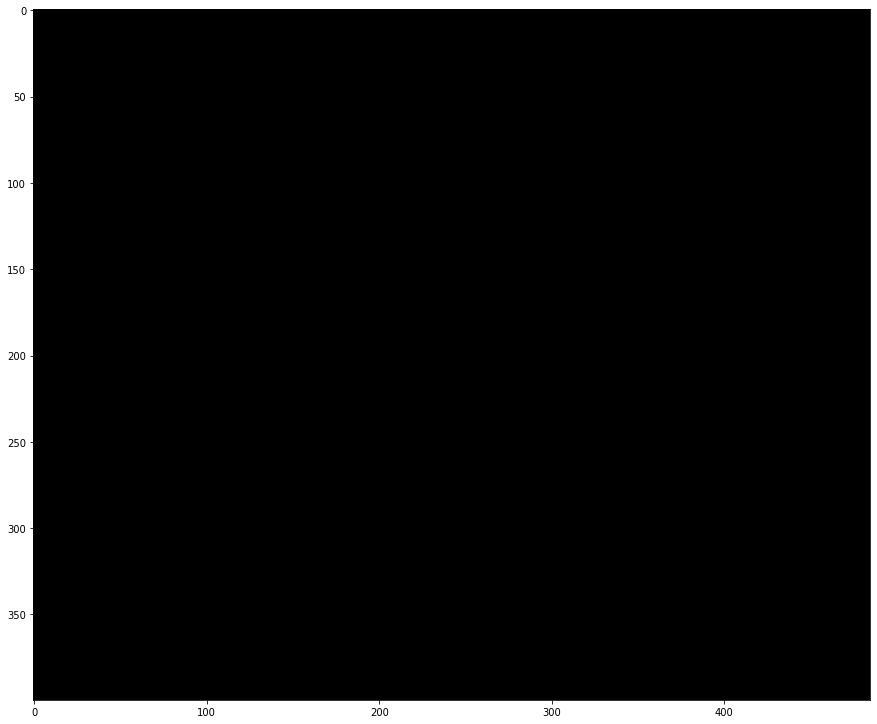

Iteration 230: loss=324899.50


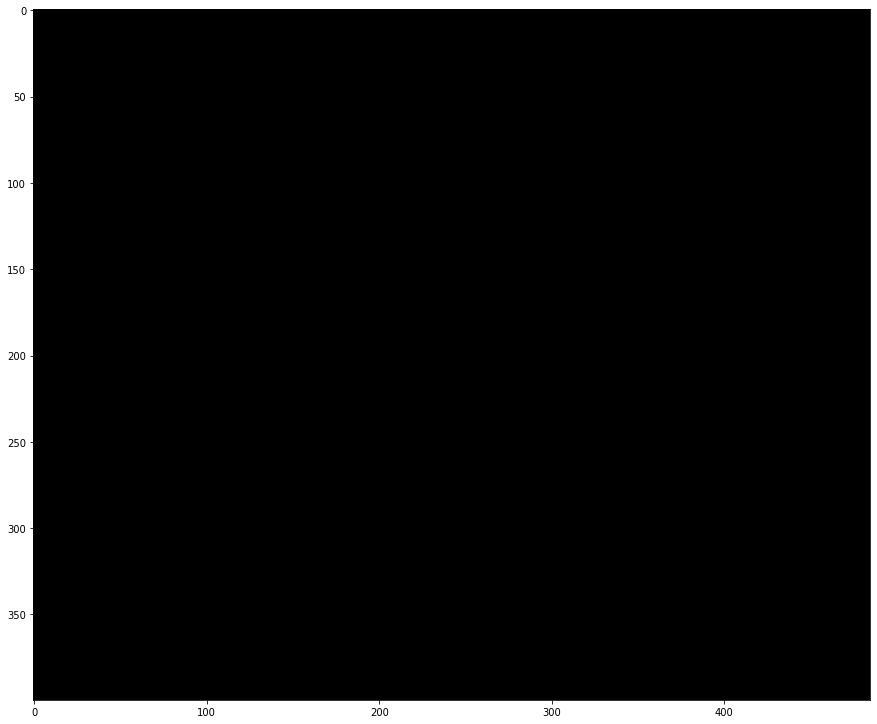

Iteration 240: loss=324899.50


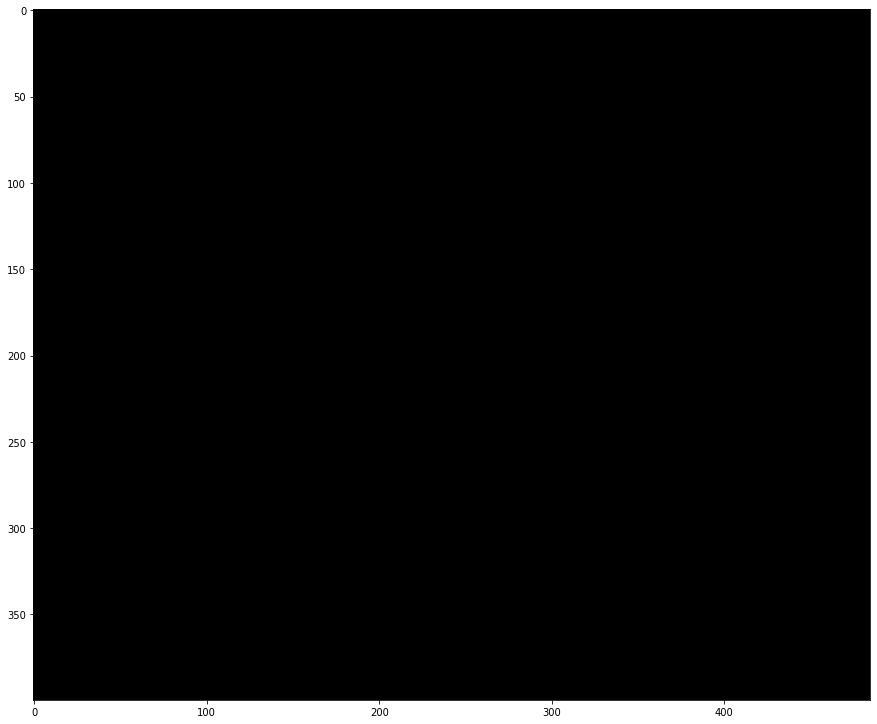

Iteration 250: loss=324899.50


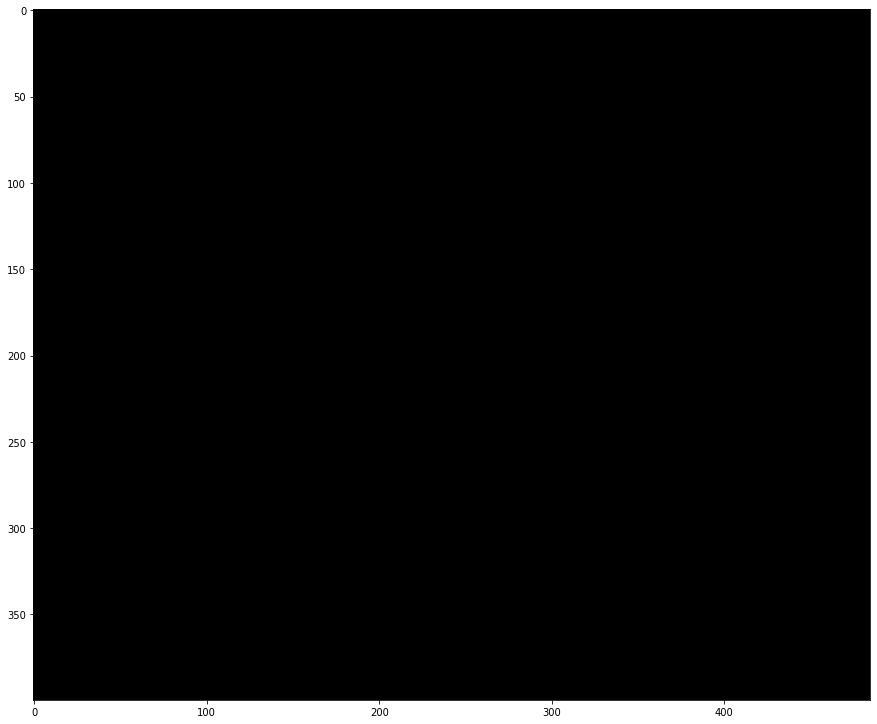

Iteration 260: loss=324899.50


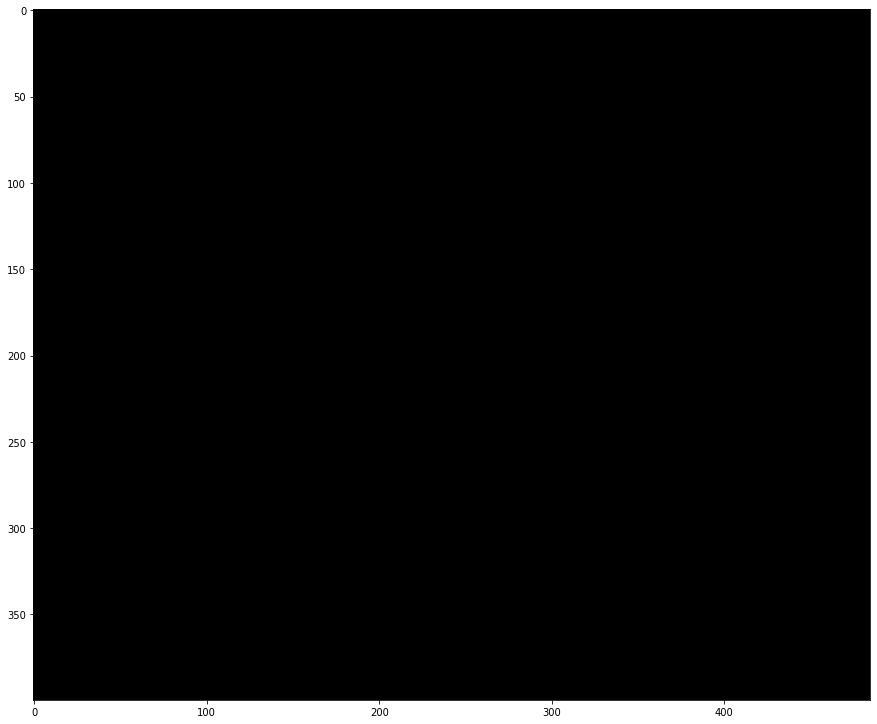

Iteration 270: loss=324899.50


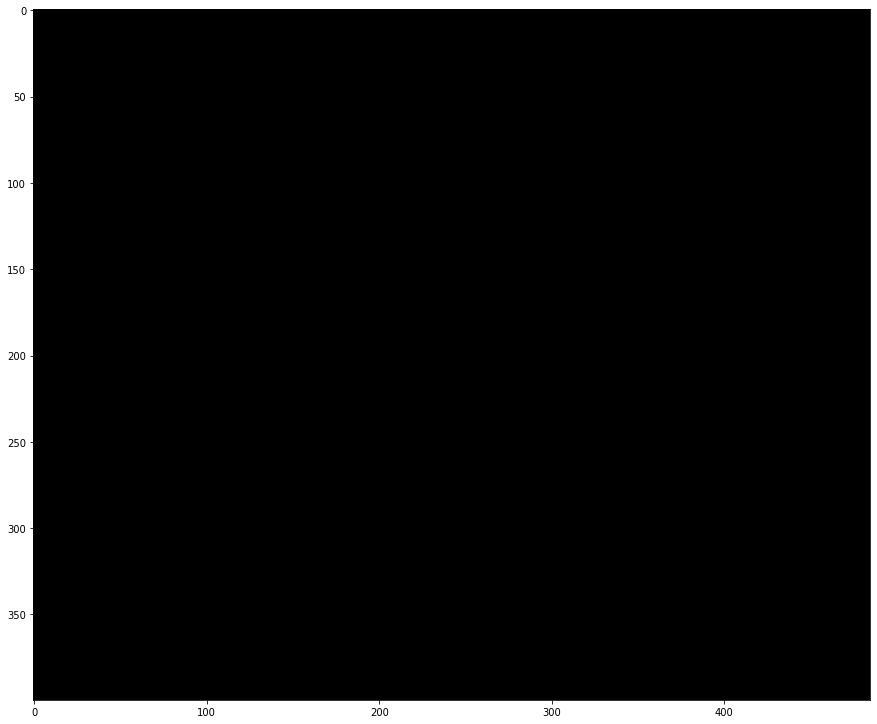

Iteration 280: loss=324899.50


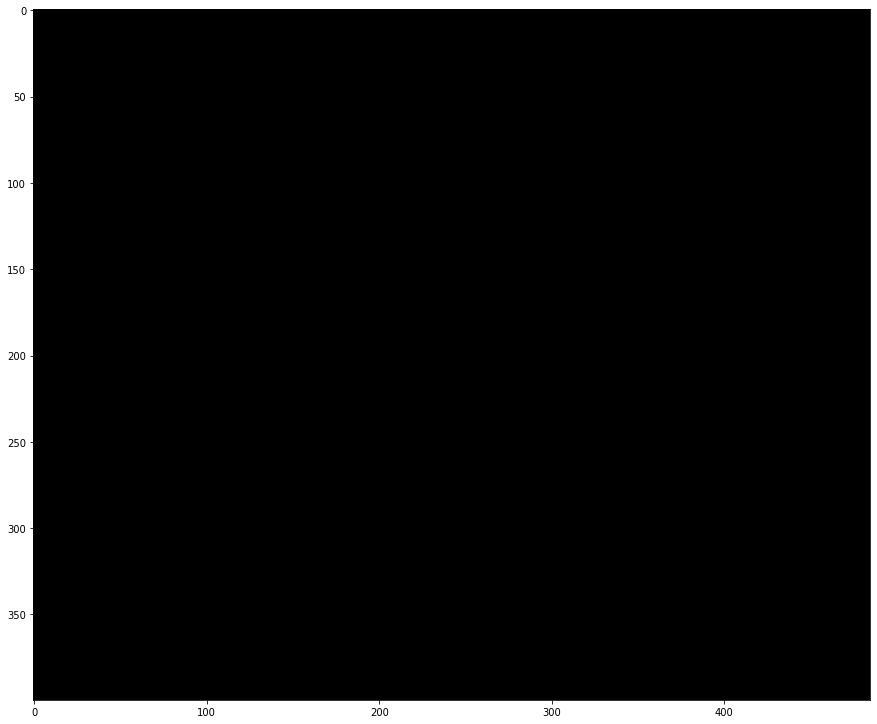

Iteration 290: loss=324899.50


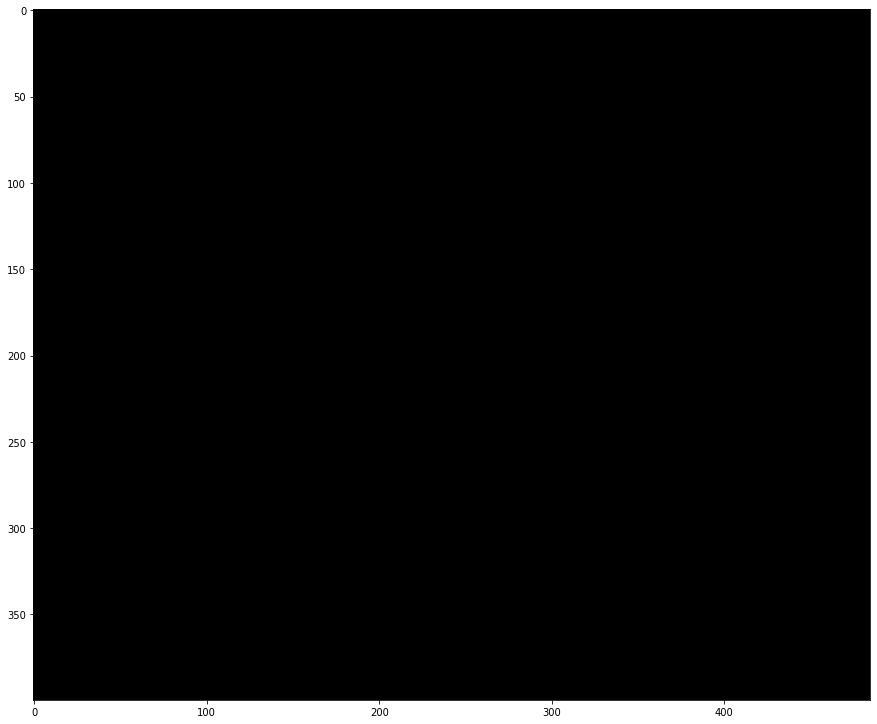

Iteration 300: loss=324899.50


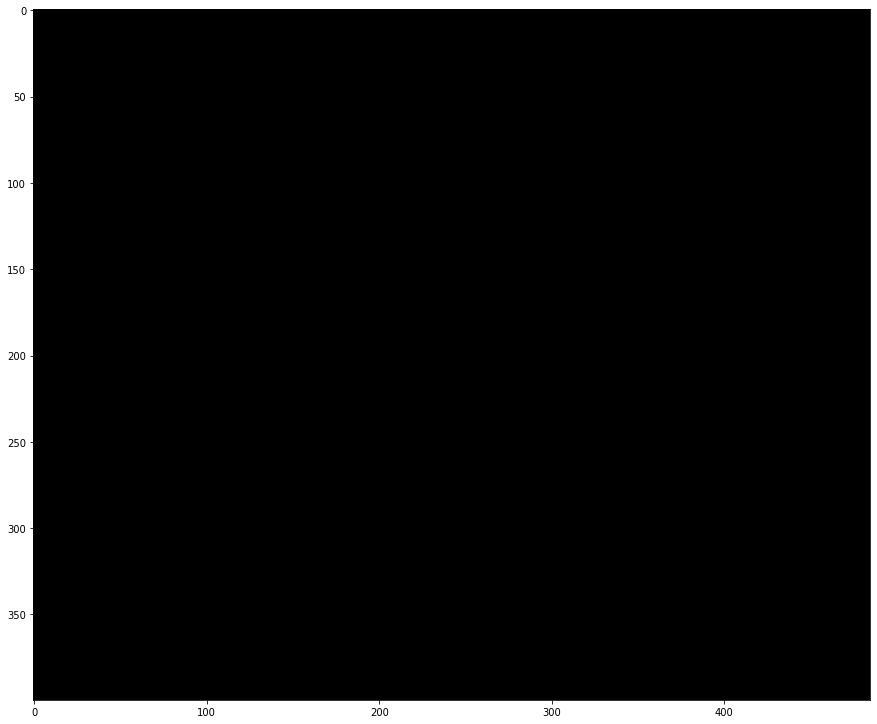

Iteration 310: loss=324899.50


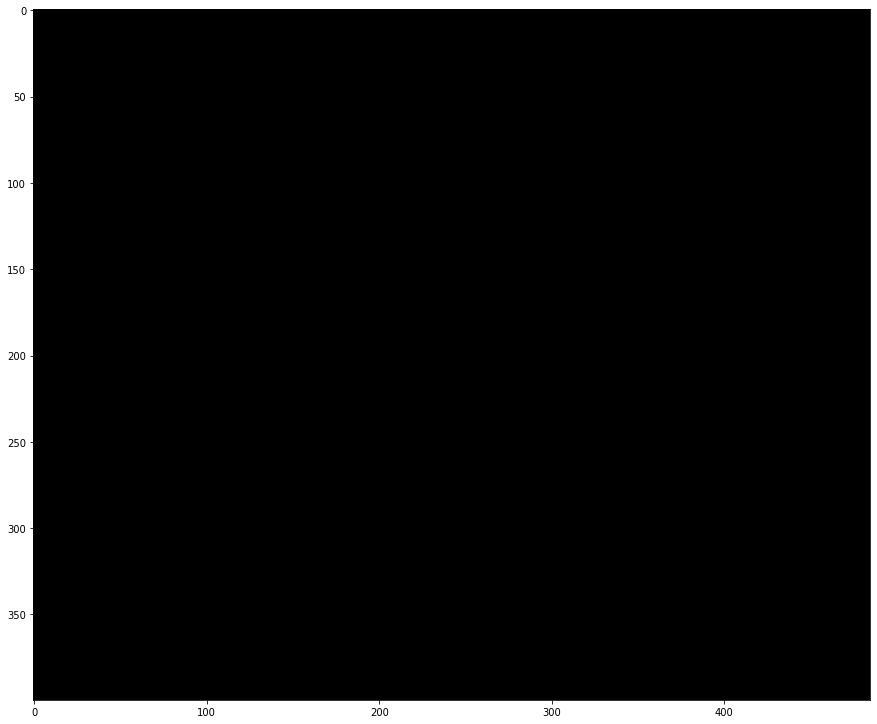

Iteration 320: loss=324899.50


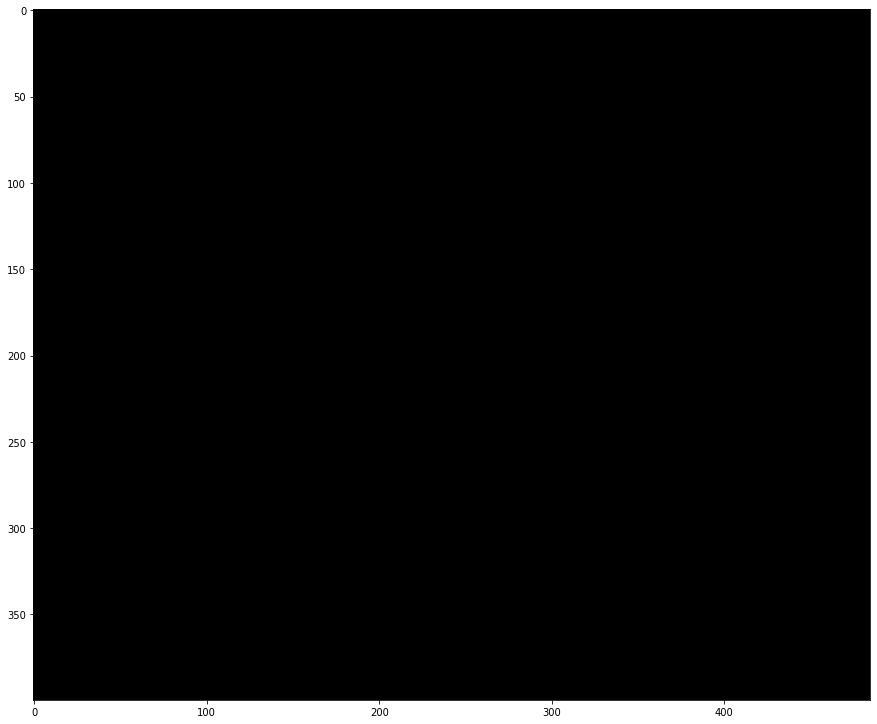

Iteration 330: loss=324899.50


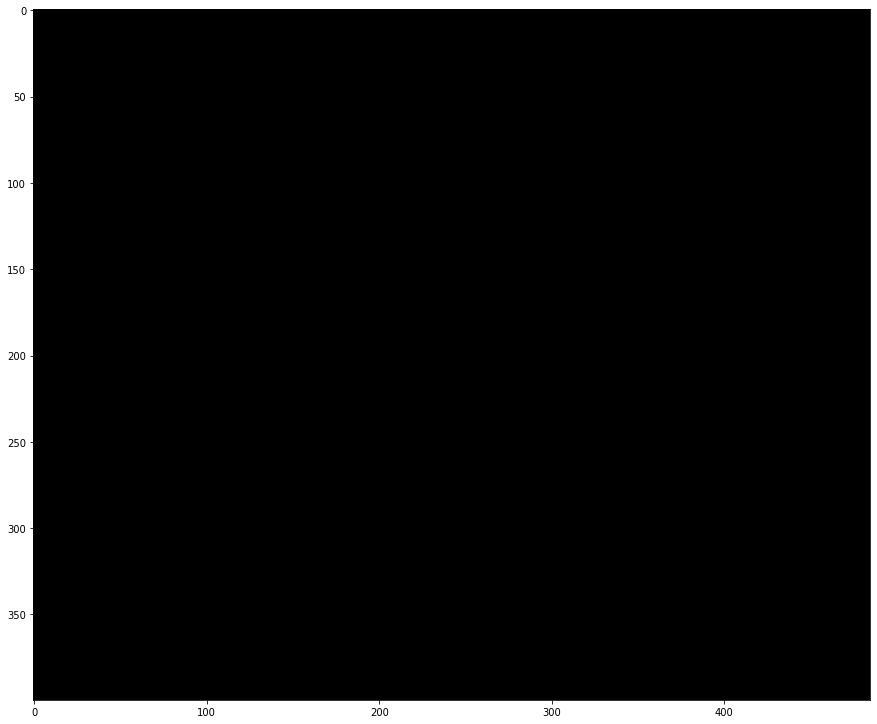

Iteration 340: loss=324899.50


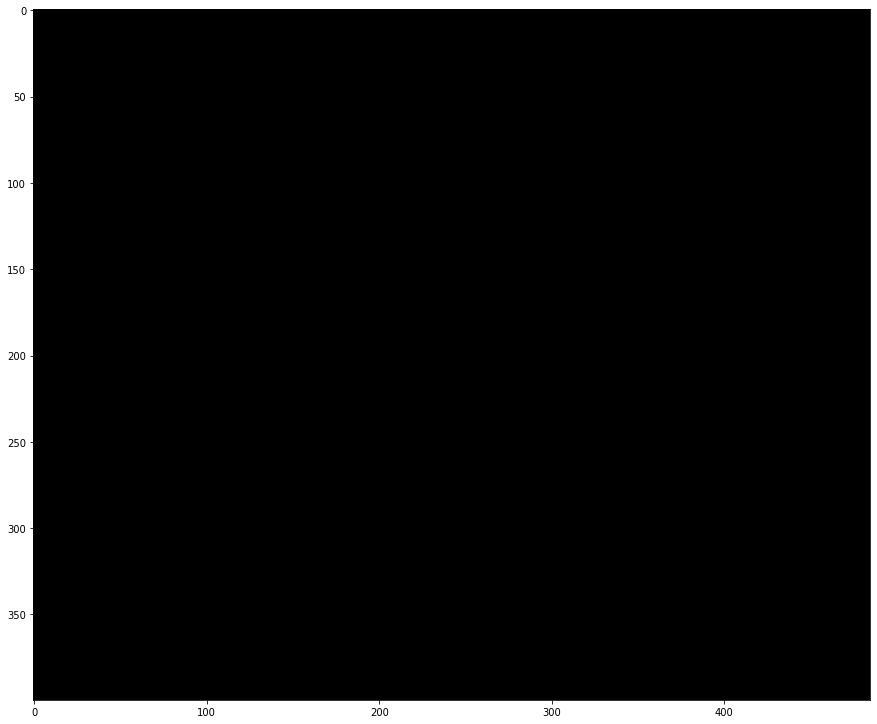

Iteration 350: loss=324899.50


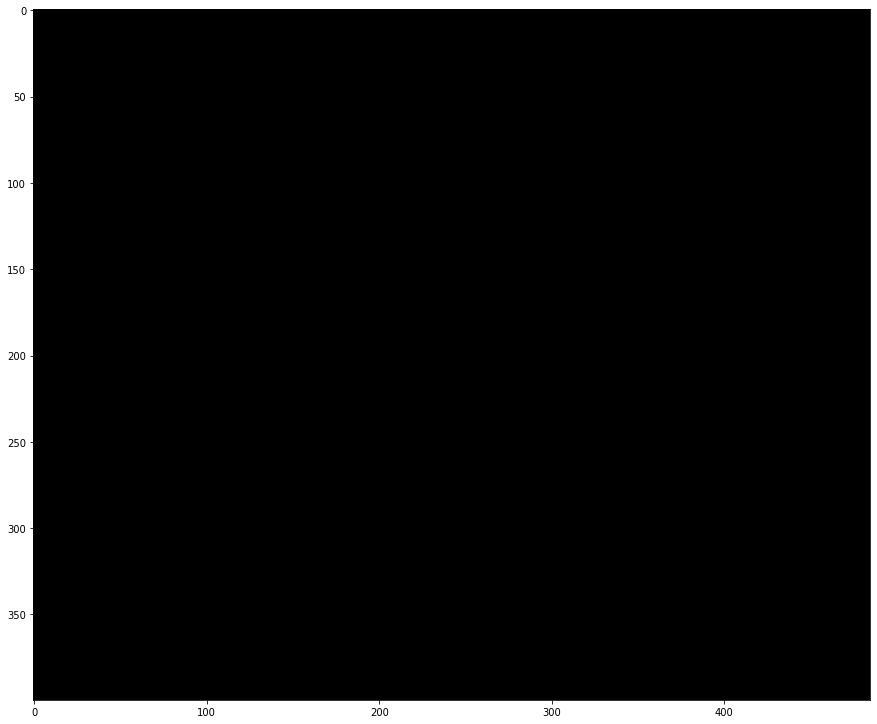

Iteration 360: loss=324899.50


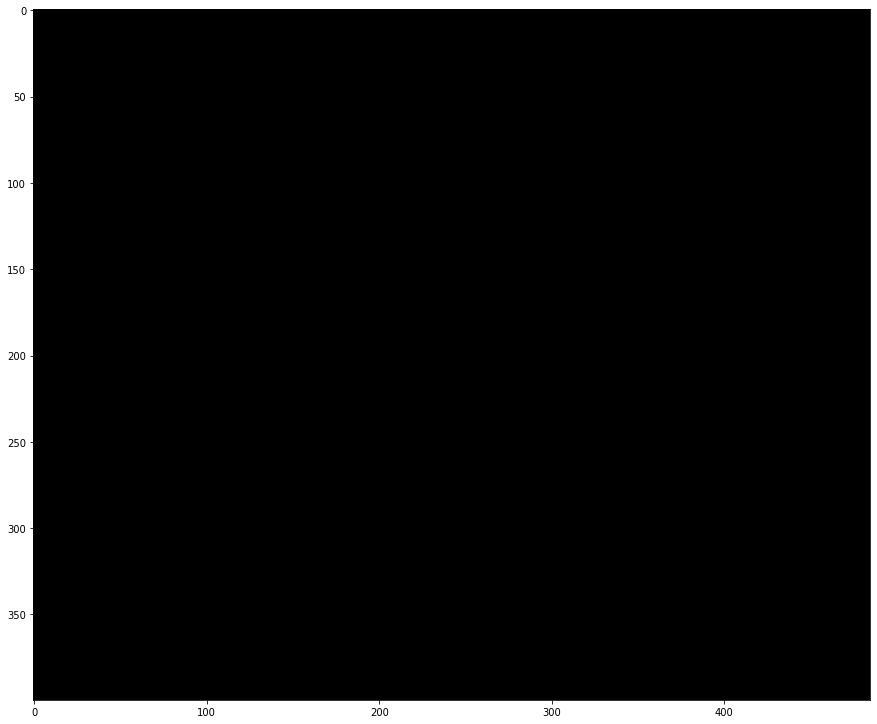

Iteration 370: loss=324899.50


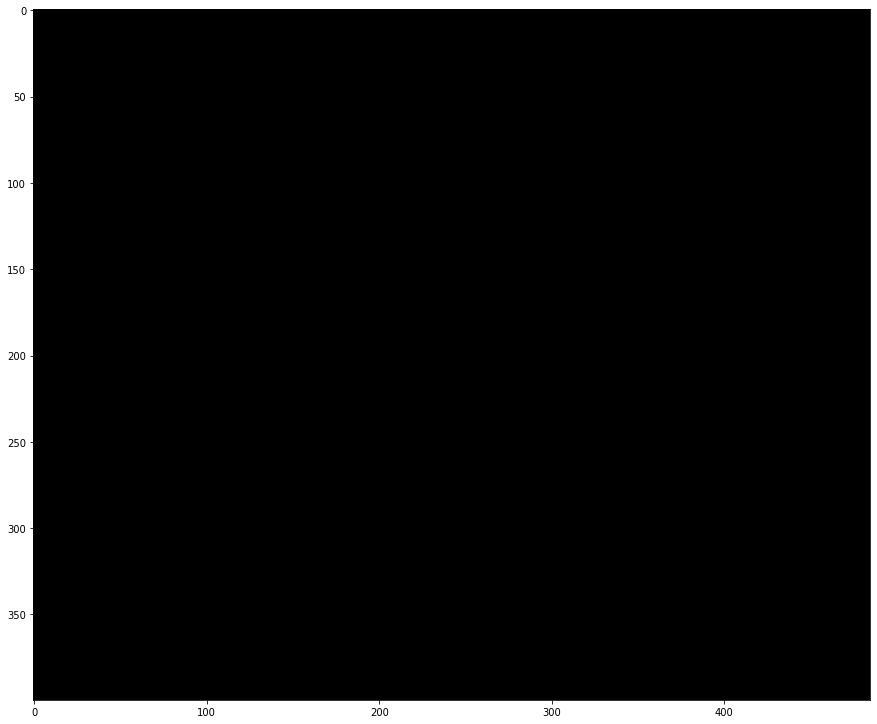

Iteration 380: loss=324899.50


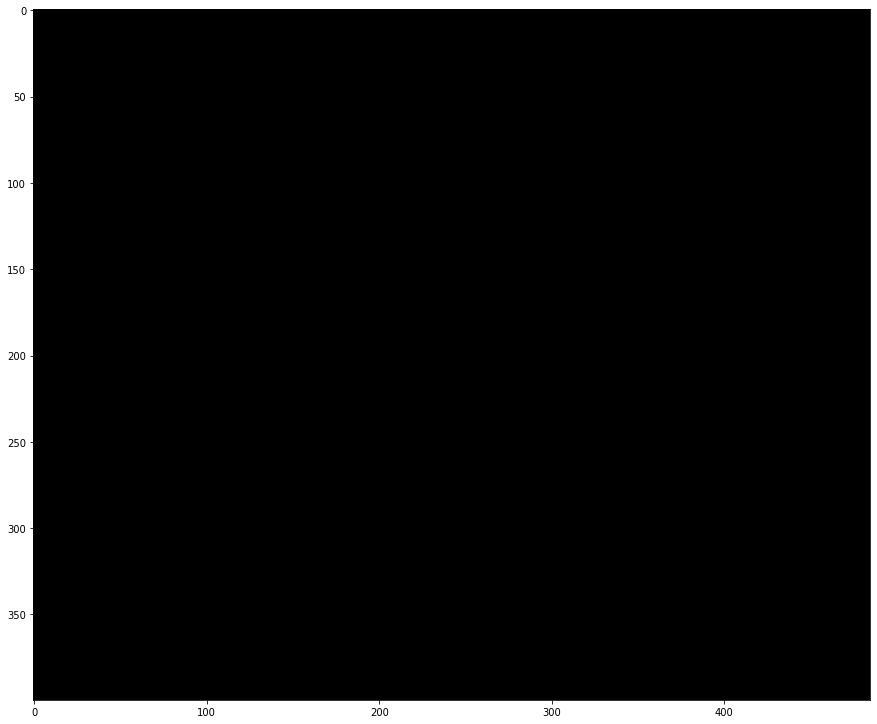

Iteration 390: loss=324899.50


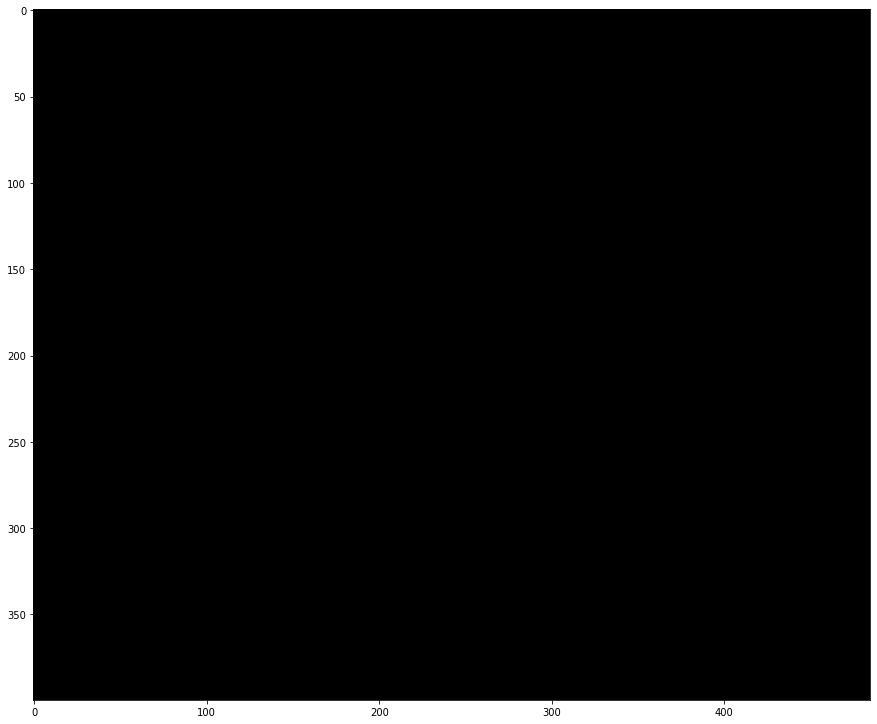

Iteration 400: loss=324899.50


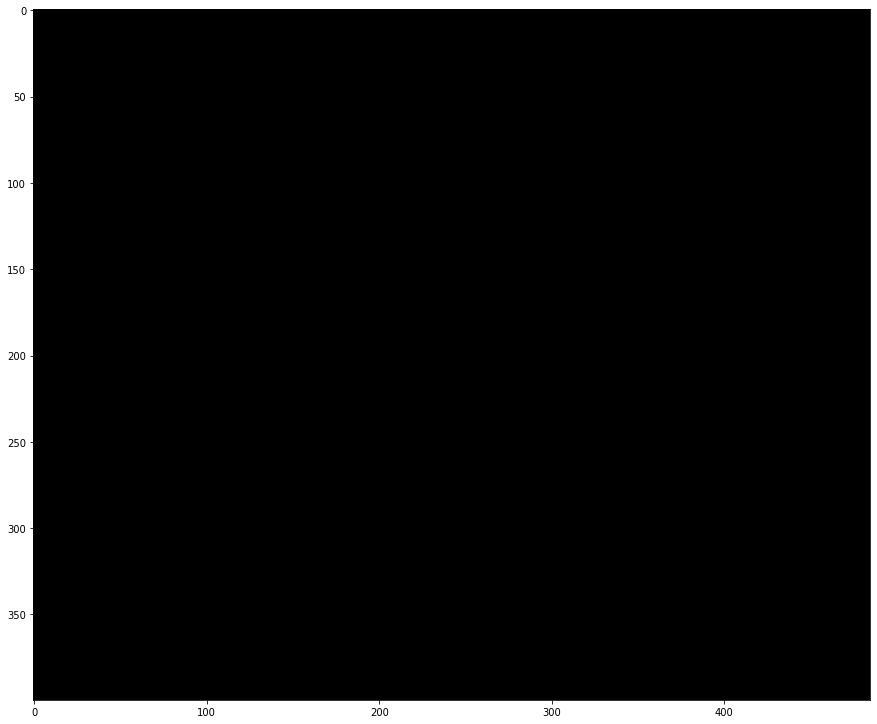

In [89]:
from keras.optimizers import SGD

width,height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
#maintain aspect ratio (weigh/height)
img_ncols = int(width * img_nrows/ height)

optimizer = SGD( keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
 )

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)

new_image = tf.Variable( preprocess_image(base_image_path))

#Try with a random noise as starting point
#print(' new image shape :', new_image.shape)
seed_image = tf.random.normal((1,img_nrows,img_ncols,3));
#print(seed_image.shape)
new_image=tf.Variable(seed_image)

#iterations = 4000
iterations = 400

for i in range(1, iterations+1):
  loss, grads = compute_loss_and_grad(new_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, new_image)] )
  if i % 10 ==0:
    print("Iteration %d: loss=%.2f" % (i, loss))
    result_saver(i, new_image[0])



In [95]:
tf.random.normal((1,4))




<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1.1954108 , 1.2769239 , 0.00343206, 0.53354037]], dtype=float32)>

In [96]:
import tensorflow.keras.layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(100*100*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((100, 100, 256)))
    assert model.output_shape == (None, 100, 100, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 100, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 200, 200, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 400, 400, 1)

    #1,400,400,3

    return model

In [97]:
#plt.figure(figsize=(15,15))
#plt.imshow(plt.imread('10_20201215_173900_image.png'))